<a href="https://colab.research.google.com/github/xian-cong/acne/blob/main/Unilever_Acne_Roboflow_ResNet_18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Check if fastai and pytorch are installed
!pip list | grep -e fastai -e torch -e torchvision

fastai                        1.0.61
torch                         1.11.0+cu113
torchaudio                    0.11.0+cu113
torchsummary                  1.5.1
torchtext                     0.12.0
torchvision                   0.12.0+cu113


In [2]:
# If not, uncomment this line and run to install them
#!pip install torch torchvision fastai

In [3]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="vcr5XJxITweIbIfriOOk")
project = rf.workspace("xian-cong").project("acne-classification")
dataset = project.version(3).download("folder")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 145 kB 31.7 MB/s 
     |████████████████████████████████| 178 kB 64.3 MB/s 
     |████████████████████████████████| 1.1 MB 47.5 MB/s 
     |████████████████████████████████| 67 kB 6.0 MB/s 
     |████████████████████████████████| 54 kB 3.4 MB/s 
     |████████████████████████████████| 138 kB 65.9 MB/s 
     |████████████████████████████████| 596 kB 11.0 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
  Created wheel for roboflow: filename=roboflow-0.2.4-py3-none-any.whl size=21356 sha256=010002a36c5ce69abe58ea5419c9397f79d17b87b936b69fbea32e89a97c1535
  Stored in directory: /root/.cache/pip/wheels/b7/2c/60/3733c0e323b1d7aec00f852264314bf6c48192c8e1dc92b3ee
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=9483d3606535bd30fd5d1c733e69d3bcc7a773d7a26e3cda14e821e861ab9847
  Stored in directory: /root/.cache/pip

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to acne-classification-3 in folder:: 100%|██████████| 1527/1527 [00:00<00:00, 1564.43it/s]


In [4]:
import os
labels = os.listdir("acne-classification-3/train")
print("No. of labels: {}".format(len(labels)))
print("-----------------")

for label in labels:
    print("{}, {} files".format(label, len(os.listdir("acne-classification-3/train/"+label))))

No. of labels: 4
-----------------
normal, 453 files
level_1, 291 files
level_0, 306 files
level_2, 330 files


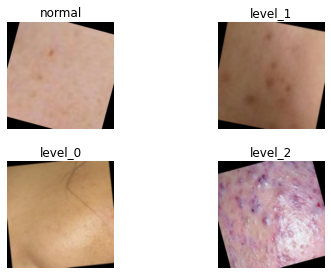

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

np.random.seed(42)

fig, ax = plt.subplots(nrows=2, ncols=2)
fig.tight_layout()
cnt = 0
for row in ax:
    for col in row:
        image_name = np.random.choice(os.listdir("acne-classification-3/train/" + labels[cnt]))
        im = Image.open("acne-classification-3/train/{}/{}".format(labels[cnt],image_name))
        col.imshow(im)
        col.set_title(labels[cnt])
        col.axis('off')
        cnt += 1
plt.show()

Alright, they look good with a wide array of images!

In [6]:
from fastai.vision import *
from fastai.metrics import accuracy

In [7]:
path = "./acne-classification-3/"
# path = "./acne-classification-1/train/"
size = 224
bs = 64

In [8]:
data = ImageDataBunch.from_folder(path,
                                  valid_pct=0.2, size=size, bs=bs)

In [9]:
# data = ImageDataBunch.from_folder(path, ds_tfms=get_transforms(do_flip=True, flip_vert=True),
 #                                 valid_pct=0.2, size=size, bs=bs)

In [10]:
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (1213 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
normal,normal,normal,normal,normal
Path: acne-classification-3;

Valid: LabelList (303 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
normal,level_0,level_2,level_0,level_0
Path: acne-classification-3;

Test: None

In [11]:
learner = cnn_learner(data, models.resnet18, metrics=[accuracy], callback_fns=ShowGraph) #resnet18 or 34

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


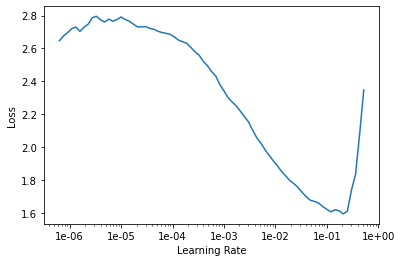

In [12]:
learner.lr_find()
learner.recorder.plot()

### First fit and evaluation
Now let's fit our model for 8 epochs, with a learning rate between 0.001 and 0.01

epoch,train_loss,valid_loss,accuracy,time
0,1.275670,0.998097,0.765677,00:08
1,0.892795,0.743409,0.811881,00:08
2,0.880464,1.535807,0.821782,00:07
3,0.871721,1.634758,0.808581,00:07
4,1.088481,5.388702,0.656766,00:07
5,1.044595,1.901320,0.762376,00:07
6,0.863624,0.809342,0.858086,00:07
7,0.710001,0.676677,0.894389,00:07
8,0.532709,0.652870,0.897690,00:07
9,0.408114,0.615403,0.894389,00:07


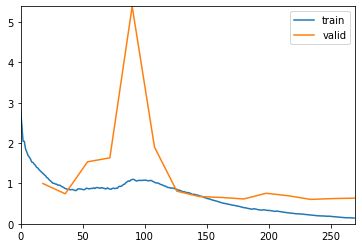

In [13]:
learner.fit_one_cycle(15, max_lr=slice(1e-3, 1e-1))

In [14]:
from fastai.callbacks import *
save_best_model = SaveModelCallback(learner, name='best_resnet')

epoch,train_loss,valid_loss,accuracy,time
0,0.095009,0.627250,0.897690,00:07


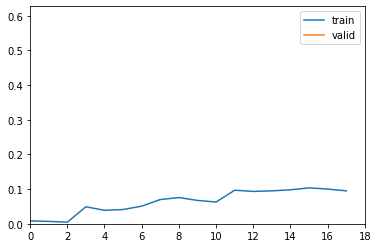

Better model found at epoch 0 with valid_loss value: 0.6272497773170471.


In [15]:
defaults.device = torch.device('cuda') # makes sure the gpu is used
learner.fit_one_cycle(1, callbacks=save_best_model)

In [16]:
learner.load('best_resnet')

Learner(data=ImageDataBunch;

Train: LabelList (1213 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
normal,normal,normal,normal,normal
Path: acne-classification-3;

Valid: LabelList (303 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
normal,level_0,level_2,level_0,level_0
Path: acne-classification-3;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, mo

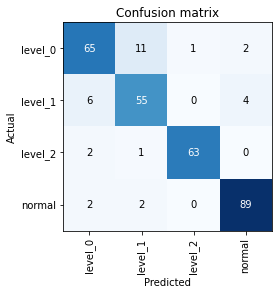

In [17]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix()

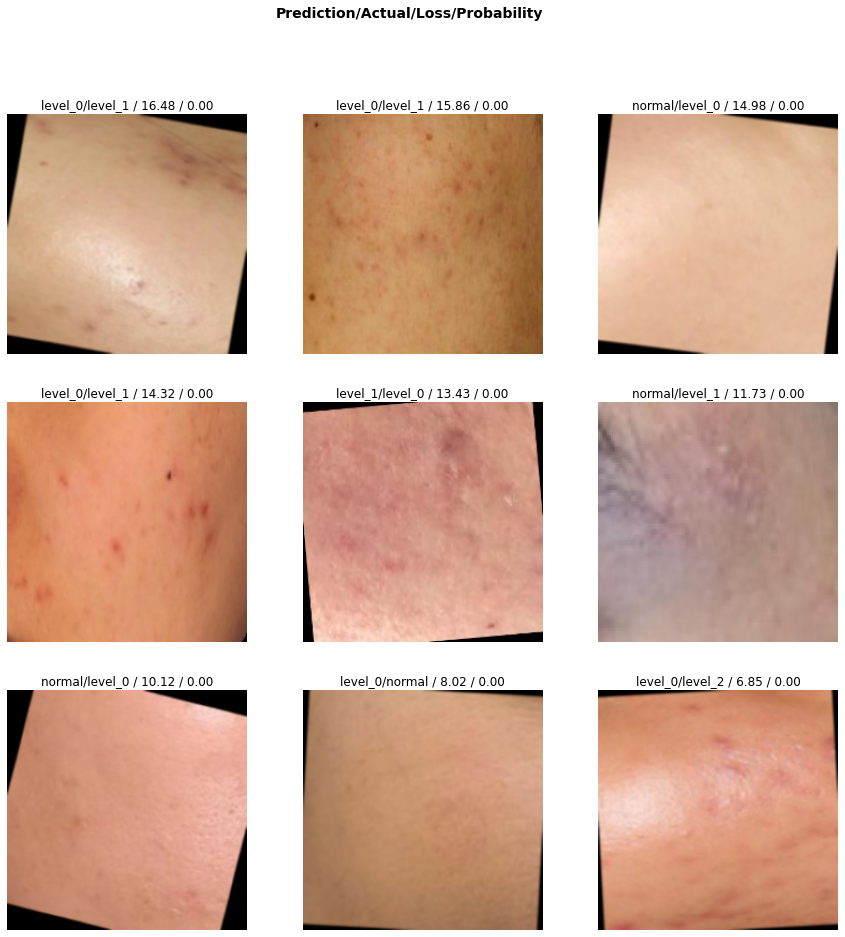

In [18]:
interp.plot_top_losses(9, figsize=(15,15))

In [19]:
#model is automatically saved with the "save_best_model" callback
%ls /content/acne-classification-1/models/best_resnet.pth

ls: cannot access '/content/acne-classification-1/models/best_resnet.pth': No such file or directory


In [32]:
import torchvision.transforms as T

image=PIL.Image.open("/content/acne-classification-3/test/normal/qwe3_jpg.rf.61239d300d5b6bfc4c48cbd5021f9470.jpg")
img_tensor = T.ToTensor()(image)
img_fastai = Image(img_tensor)
# img = open_image(img_fastai)
output = learner.predict(img_fastai)
print(output)
print(output[2])
classIdx = np.argmax(output[2])
print(data.classes[classIdx])

(Category tensor(3), tensor(3), tensor([1.0767e-21, 6.4417e-21, 5.8578e-23, 1.0000e+00]))
tensor([1.0767e-21, 6.4417e-21, 5.8578e-23, 1.0000e+00])
normal


In [28]:
data.classes

['level_0', 'level_1', 'level_2', 'normal']